<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations. 

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height. 

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [116]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1.  1D shallow water equations


Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation. 

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [117]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1) 
H.change_scales(1) 
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

2024-12-19 23:37:47,646 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s
2024-12-19 23:37:47,649 __main__ 0/1 INFO :: Starting main loop
2024-12-19 23:37:47,834 solvers 0/1 INFO :: Simulation stop time reached.
2024-12-19 23:37:47,835 solvers 0/1 INFO :: Final iteration: 100
2024-12-19 23:37:47,835 solvers 0/1 INFO :: Final sim time: 6000.0
2024-12-19 23:37:47,836 solvers 0/1 INFO :: Setup time (init - iter 0): 0.1954 sec
2024-12-19 23:37:47,837 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0627 sec
2024-12-19 23:37:47,838 solvers 0/1 INFO :: Run time (iter 10-end): 0.1221 sec
2024-12-19 23:37:47,839 solvers 0/1 INFO :: CPU time (iter 10-end): 3.391e-05 cpu-hr
2024-12-19 23:37:47,840 solvers 0/1 INFO :: Speed: 1.507e+06 mode-stages/cpu-sec


In [118]:
print(h_save.shape)

(101, 512)


### 1.2  Plotting
The code below will make a movie of the height.

2024-12-19 23:37:49,135 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-19 23:37:49,137 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/tmpu__kx9mz/temp.m4v


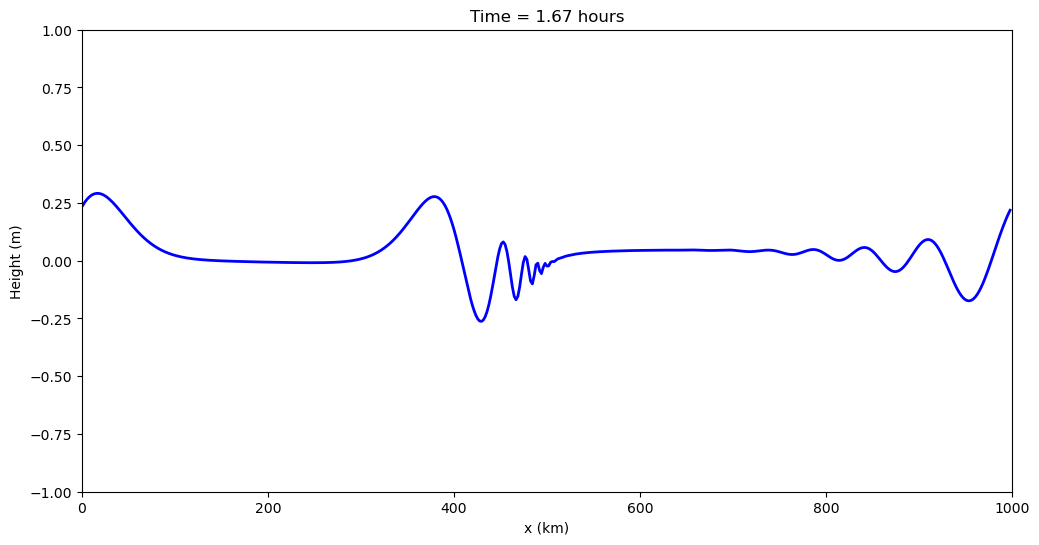

In [119]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))            
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)    

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value. 

<font color='darkorange'>

The expected wave speed for this scenario is given by: $$v_p = \frac{\omega}{k} = \pm \sqrt{gH} \\[10pt] v_g = \frac{\partial \omega}{\partial k} = \pm\sqrt{gH}$$ 

The height, $H$ is given by: $H = H_0 - h_b(x) + h(x, t)$

We can see here that the phase and group velocities are the same so the wave is non-dispersive
</font>

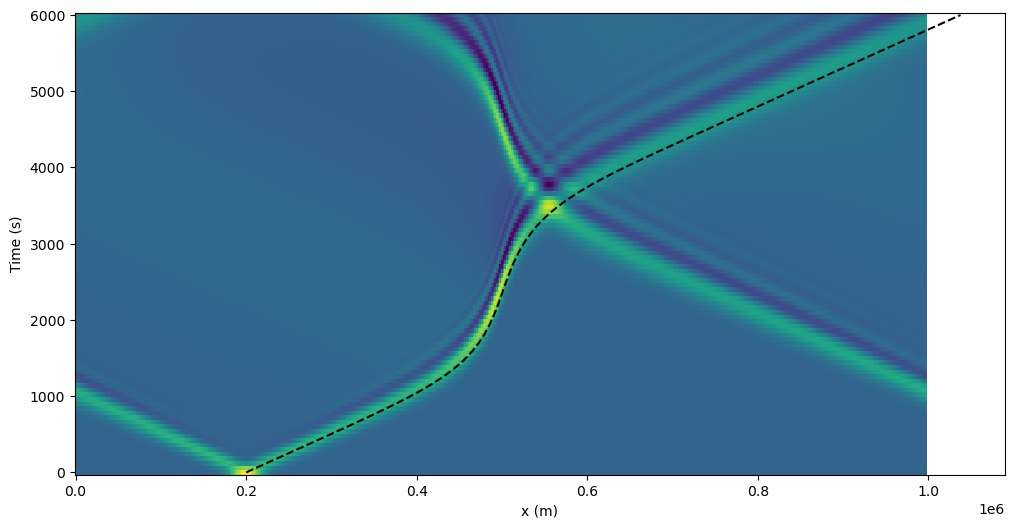

In [120]:
x_synth = np.zeros(len(t_save))
x_synth[0] = 200*kilometer

for i in range(1,len(t_save)):
    H_curr = H0-(H0-H_min)*np.exp(-(x_synth[i-1]-x2)**2.0/w2**2.0) 
    c_curr = np.sqrt(H_curr*g)
    x_synth[i] = x_synth[i-1] + c_curr*timestep

fig = plt.subplots(figsize=(12,6))
plt.xlabel('x (m)')
plt.ylabel('Time (s)')
plt.pcolormesh(x, t_save, h_save)
plt.plot(x_synth, t_save, 'k--')
plt.show()
                

<font color='darkorange'>

The code above plots a graph of the height of surface, as a function of both x and t. 

We can plot using the black dashed line, our theoretically predicted location of the maxima of the wave as a function of x and t, using the theoretical equations provided. 

We can see that the dedlaus method, gives good agreement with the theorecially predicted behaviour of the system. 

The speed of the propagating wave is given by 1/gradient of the black dashed line. Therefore the behaviour of the wave is as expected, as when travelling over the shallower region of water, the gradient of the line covering the peaks of the waves increases, corresponding to a decrease in the velocity, as predicted by the shallow water equations. 

</font>

## 2.  2D Shallow water equations



Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [121]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

2024-12-19 23:37:55,429 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 9.0e+01/s
2024-12-19 23:37:55,455 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2024-12-19 23:37:55,489 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2024-12-19 23:37:55,525 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2024-12-19 23:37:55,562 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2024-12-19 23:37:55,596 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2024-12-19 23:37:55,629 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2024-12-19 23:37:55,663 subsystems 0/1 INFO :: Building subproblem matric

### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

2024-12-19 23:37:56,350 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-19 23:37:56,354 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/tmp5ekhddqz/temp.m4v


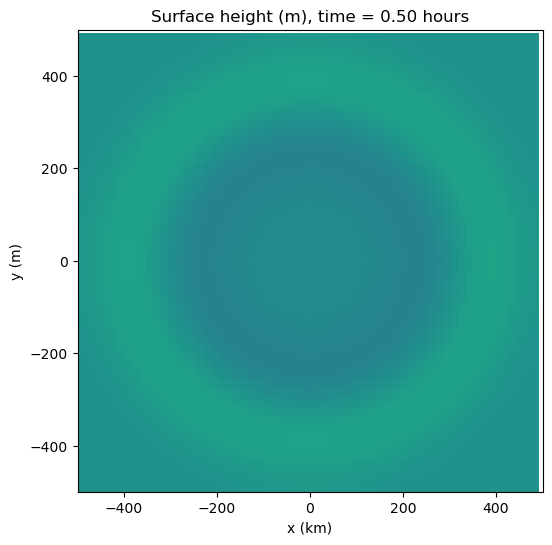

In [122]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))   
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))            
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>


Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cells below, provide an expression for the expected wave amplitude as a function of distance from the origin (x=0, y=0) and explain clearly the reasoning behind this expression. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation. 

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

<font color='orange'> In order to investigate this problem we are going to do the following: 

1. Firstly look at at the slice of y=0 and check to see what the velocity profile of the propagating wave is:
2. Then we will look at the amplitude of the peak of the wave and how this changes over time as the wave propagates away from the central point 

We would expexct that the Energy intensity scales as $E \propto \frac{1}{r}$ which means that we would expect the amplitude of the wave to follow a relationship: $$ A \propto r^{-\frac{1}{2}} $$ </orange>

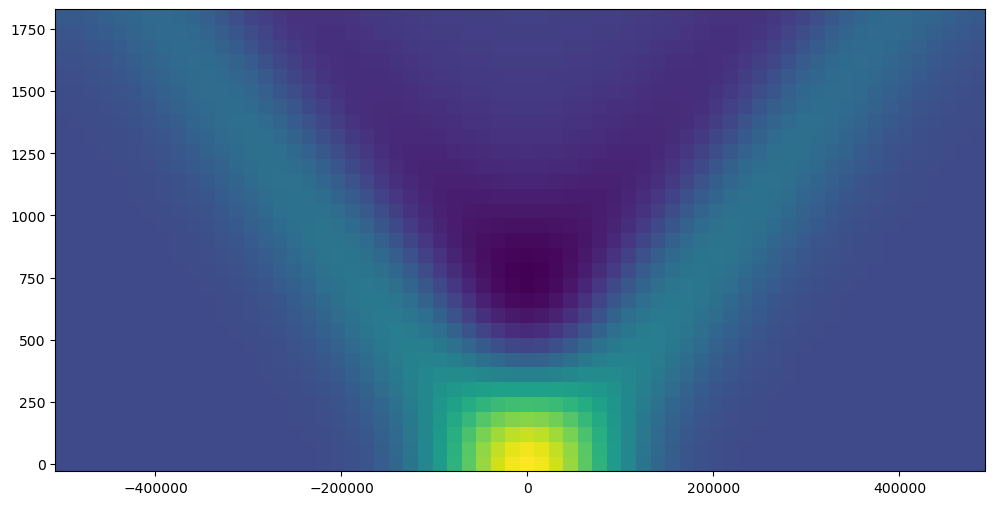

In [123]:
# We are going to extract an x-slice at y=0 and plot it as a function of x and time to see the wave propagation

# Extract the x-slice at y=0

h_xslice = h_save[:,:,Ny//2]

# Now we can run the same code as before to plot the x-slice as a function of x and time
# Need to convert x into a 1D array:
x_1D = x[:,0]

# This first figure is to check that we have the correct behaviour of the wave
fig = plt.subplots(figsize=(12,6))
plt.pcolor(x_1D, t_save, h_xslice)
plt.show()



R^2 value: 0.9549099746077778
[ 6.35571878 -0.19905446]


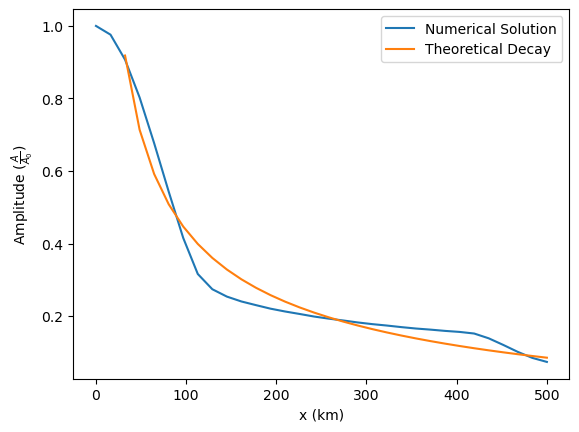

In [124]:
# We want to actually look at the amplitude of the
from scipy.optimize import curve_fit

# First let's isolate the horizontal slice at y=0 (The wave is circularly symmetric so we can just look in one direction)
h_xslice_half = h_save[:,Nx//2:,Ny//2]

# We want to find the maximum value of the wave at each time step
max_values = np.max(h_xslice_half, axis=0)

# Need to redefine an x array to plot with:
x_plotting = np.linspace(0.1, 500, 32)

x_plotting_fit = x_plotting[2:]  # Slice to exclude the first 7 points
max_values_fit = max_values[2:]  # Slice to exclude the first 7 points

def theoretical_decay(x, A_0, B_0):
    return A_0 * x**(-1/2) + B_0

popt, pcov = curve_fit(theoretical_decay, x_plotting_fit, max_values_fit, maxfev=10000)

fig, ax = plt.subplots()
ax.plot(x_plotting, max_values, label="Numerical Solution")
ax.plot(x_plotting_fit, theoretical_decay(x_plotting_fit, *popt), label="Theoretical Decay")

# Let's also get a R^2 value for this fit to see how well it fits
residuals = max_values_fit - theoretical_decay(x_plotting_fit, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((max_values_fit - np.mean(max_values_fit))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2 value: {r_squared}")

ax.set_xlabel("x (km)")
ax.set_ylabel("Amplitude $(\\frac{A}{A_0})$")
ax.legend()
print(popt)





<font color='darkorange'>

The first graph is the same thing as was plotted in Section 1, but for a 1D slice of the 2D field (along y=0). As the problem is circularly symmetric, we can just consider a 1D representation of the problem. The first plot verifies that along y=0 there is a wave tavelling in both the positive and negative directions, with constant velocity, as expected. 

The second plot shows the maximum amplitude of the wave as a function of distance from the centre. Here x is synonomous with radius as due to the symmetry of the problem. A theoretical curve following the $r^{-1/2}$ law previously derived is plotted over the top. It is not plotted for the first few time step to allow the model to overcome any spin up issues that can be seen in the first few iterations of the model running. 

The dedalus model gives decent agreement with theoretically predicted wave profiles, producing an $R^2$ values of $0.95$.

Changing the intial height of the wave gives broadly the same wave profile, with decent agreement in the centre region of the graph. Spin up errors are still observed, so the peak amplitude of the wave close to the origin of the wave, is not well represented in the model when compared to the theoretical profile. Addionally, at the edges of the model, further errors can be seen. These could be due either to edge effects if periodic boundary conditions are used, or could be due to coarsening of the spatial field relative to the circumference of the waves as it moves away from the source point.

</font>

## 3. Shallow water equations on a sphere



Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. As a reminder, the colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole.This geometry also allows us to take into account the Earth's rotation. 

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [125]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
#h.change_scales(1) # Set values on regular grid
#u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
#u['g'][0] = 0
#u['g'][1] = 0

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

2024-12-19 23:38:09,304 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 4s, Rate: 1.4e+01/s
2024-12-19 23:38:09,367 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s
2024-12-19 23:38:09,445 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 6.7e+01/s
2024-12-19 23:38:09,542 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 6.8e+01/s
2024-12-19 23:38:09,629 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s
2024-12-19 23:38:09,704 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+01/s
2024-12-19 23:38:09,779 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 7.7e+01/s
2024-12-19 23:38:09,872 subsystems 0/1 INFO :: Building subproblem matri

### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

2024-12-19 23:39:06,389 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-19 23:39:06,390 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/tmpzemcr275/temp.m4v


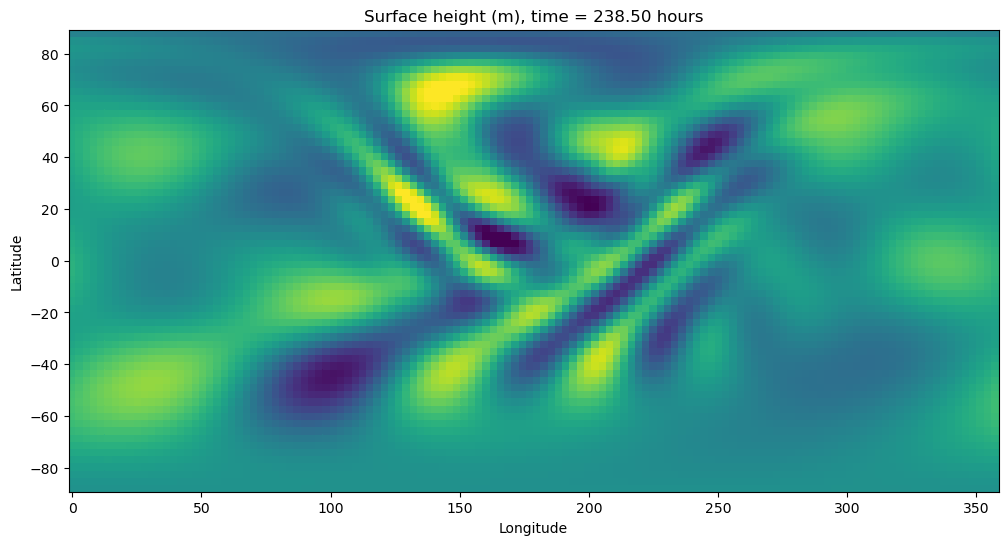

In [126]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)  

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels         
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>



Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Explain the physical mechanisms that cause the shape of the wave to vary.

<font color='darkorange'> 

There are a number of factors that will influence the shape of the wave:
1. Earth's rotation and the Coriolis force - The coriolis force is a function of latitude meaning that the shallow water equations vary in space. At the equator, the coriolis force is 0, but at the poles it is much stronger. This will affect teh shapes of the wave as it moves across the curved surface of the Earth. 
2. Topography - the Earth is a shere and not flat - therefore what we view is a 2D representation of the surface of a 3D sphere. This affects how the waves look when viewed in 2D. In particular, convergence and divergence effects at the poles, will for interesting looking wave profiles, that only properly make sense when considered on the surface of a sphere and not on a flat plane displayed in the code below. 
3. Shallow water approximations - these are not true across the whole surface of the Earth. They assume that the vertical velocity is very small compared to it's horizontal motion. This may impact how the waves look if the shallow water approximation is not applied everywhere. 

</font>

#### 3.3.1 Looking at specific point over time

First we need to determine how the grid that the model uses, (in therms of longitude and colatitude) relates to requested latitude and longitude coordinates. 

Out model consits of:
* 145 time steps 
* 128 longitude divisions 
* 64 colatitude divisions 


In [127]:
theta_target = np.pi / 4  # 45° North
phi_target = +3*np.pi / 2  # 90° West

theta_idx = np.argmin(np.abs(theta - theta_target))
phi_idx = np.argmin(np.abs(phi - phi_target))

print(theta_idx, phi_idx)

raw_data = h_save[:, phi_idx, theta_idx]

48 96


Text(0.5, 0, 'Time (hours)')

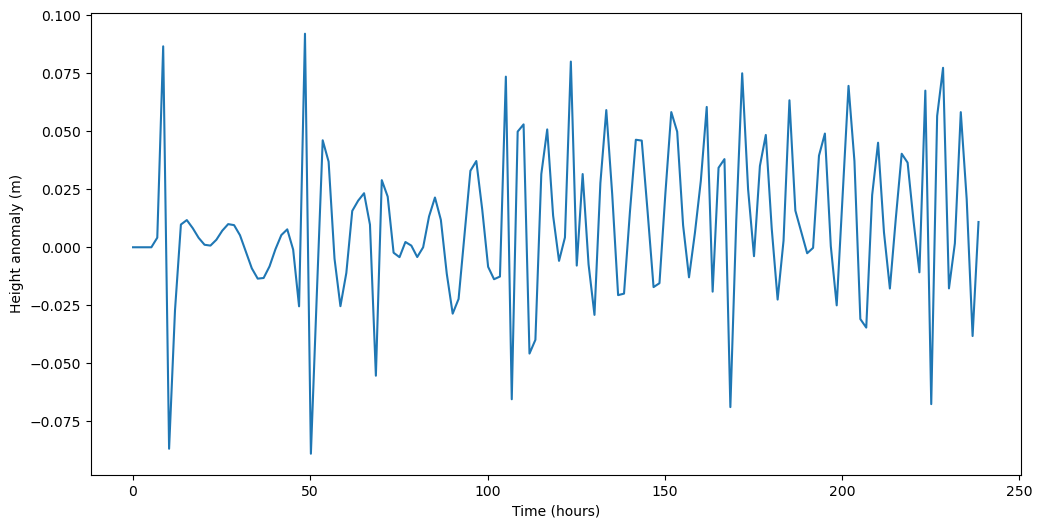

In [128]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.array(t_save)/3600, raw_data)
ax.set_ylabel("Height anomaly (m)")
ax.set_xlabel("Time (hours)")

<font color='darkorange'> 

Above is plotted the height anomaly (height of the wave) over for the location requested. The major peaks correspond to the large wavefronts passing over the location. Further higher frequency oscillating modes can also be observed. 

</font>

#### 3.3.2 Incorporating forcing function into the dedalus script 

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [129]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians
tau = 0.1*day # This has been added for this new problem

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

f = dist.Field(name='f', bases=basis)
f['g'] = 1 + 0.5*np.tanh((phi - 3*np.pi/2)/(np.pi/10)) - 0.5*np.tanh((phi - np.pi/2)/(np.pi/10))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'][0] = 0
u['g'][1] = 0

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u) - (1/tau)*f*h")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

2024-12-19 23:39:38,014 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 7.9e+01/s
2024-12-19 23:39:38,076 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 9.4e+01/s
2024-12-19 23:39:38,146 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 9.7e+01/s
2024-12-19 23:39:38,217 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 9.7e+01/s
2024-12-19 23:39:38,289 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 9.7e+01/s
2024-12-19 23:39:38,362 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 9.7e+01/s
2024-12-19 23:39:38,434 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 9.7e+01/s
2024-12-19 23:39:38,506 subsystems 0/1 INFO :: Building subproblem matri

2024-12-19 23:40:37,314 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-19 23:40:37,316 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/tmpdtu9d8rw/temp.m4v


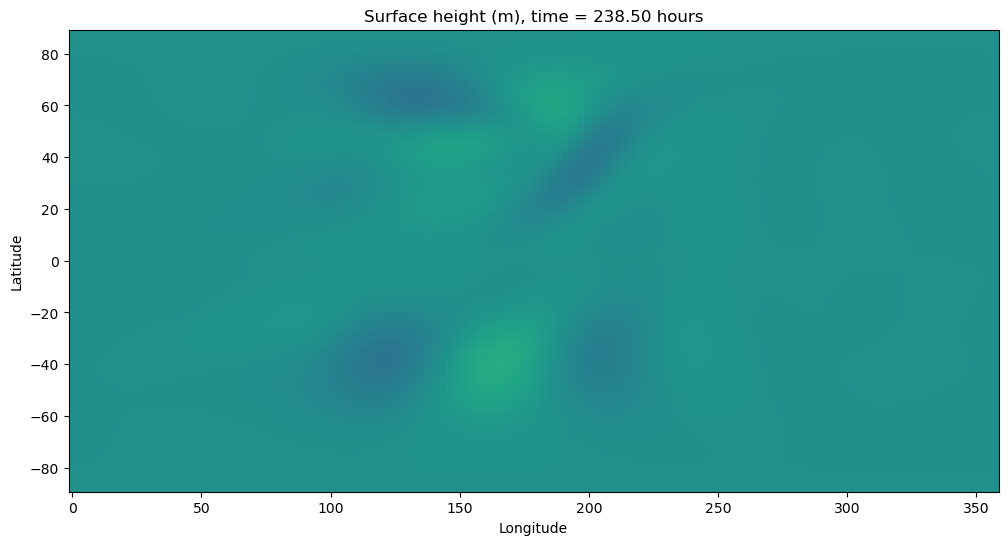

In [130]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)  

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels         
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

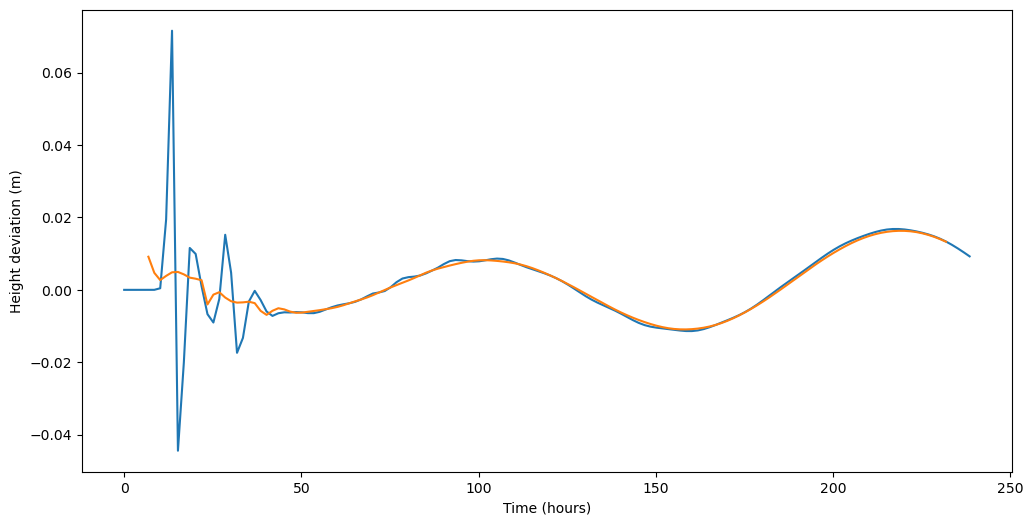

In [131]:
# Let's pick a position to test the phase speed of the rosby waves: 

theta_target = 3*np.pi / 4  # 45° South
phi_target = np.pi   # 180° East

theta_idx = np.argmin(np.abs(theta - theta_target))
phi_idx = np.argmin(np.abs(phi - phi_target))


raw_data = h_save[:, phi_idx, theta_idx]

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.array(t_save)/3600, raw_data, label="Numerical Solution")
# Now let's find rolling aveage of the data 
rolling_average = np.convolve(raw_data, np.ones(10)/10, mode='valid')
ax.plot(np.array(t_save[5:-4])/3600, rolling_average, label="Rolling Average")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Height deviation (m)")
plt.show()

<font color='darkorange'>

Following the addition of the forcing terms into the equation, the much slower travelling Rosby waves can now be observed. By selecting the point 45º South and 180º East, we can look at the properties of these waves. The Rosby waves travels Westward as expected. 

From the still image at the end of the wideo, we can see that the wavelength of the Rosby waves is of the order 80 degrees in longitude at 45º South. At this latitude, we can calculate that this gives the Rosby waves a wavelength of the order $5,000km$ which is in line with the literature values for planetary Rosby waves. 

From the line graph (graph 2) we can estimate that the time period of the Rosby waves is of the order 120hours or $\approx 5\times 10^5 s$. 

The Rosby wave velocity is given by:

$$ c \equiv \frac{\omega}{k} = U - \frac{\beta}{k^2 + l^2},$$

where,

$$ \beta = \frac{2\Omega \cos(\phi)}{a},$$

with $a$ being the radius of the Earth and $\Omega$ is the Earth's angular velocity. 

At 45º South, the coriolis parameter can be calculated to be: $\beta = 1.62 \times 10^{-11} m^{-1} s^{-1}$, and with $k = 2\pi / \lambda$, the expected Rosby wave speed can be calculated to be of the order: $$c = 10ms^{-1}.$$

This is roughly an order of magnitude above the expected Rosby wave phase speeds that were derived in lectures. However, this may be because the forcing/damping term that is being applied is not strong enough to properly represent the full force of damping that occurs in the real planetary system. 

The Rosby waves however, do have the correct shape, with them travelling in the correct direction (East to West). Issues with trying to represent a 3D Earth model in a 2D simulation can also be seen with weird looking wave fronts at the poles of the model. 

</font>

## 4. Optional further investigations



* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?